# TODO
- remove reliance on rrow, like audio constants dict
- make into functions better
- show pinyin on top of character

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# !pip install gtts pydub audioop-lts
import time
import os
import pandas as pd
from collections import defaultdict
from PIL import Image, ImageDraw, ImageFont
from moviepy import ImageClip
from utils_data import (
    load_raw_data, check_dups, filter_df_to_vocab_of_interest, 
    fill_default_settings, delete_previous_attempt_files
    )
from utils_video import (
    combine_clips_with_audio_to_create_video, create_icon_from_slide,
    draw_word_index, draw_logo, draw_previous_word, draw_previous_sent,
    draw_vocab_based_on_format, generate_intro_slide,
    generate_word_list_slide, generate_outro_slide,
    overlay_one_image_on_another
)
from utils_audio import (
    create_tts_files_for_one_vocab_word, compute_pinyin_and_create_recordings,
    combine_audio_files_and_compute_durations,
    generate_nonvocab_audio_and_compute_durations, create_final_audio_from_each_word_and_nonvocab
)
pd.options.display.max_columns = 100
pd.options.display.max_rows = 130

In [3]:
# reload configs
from configs.v008_cats import (
    data_settings, output_path,
    video_configs, icon_configs,
    nonvocab_slides, subtitle_text_configs,
    DEFAULT_TEXT_PROPERTIES,
)
subtitle_text_configs['font'] = ImageFont.truetype(subtitle_text_configs['font_name'], subtitle_text_configs['font_size'])

In [4]:
truly_load_data = False
to_delete = True

# 0. Create dataframe of settings

In [5]:
# Create settings df
data_settings = fill_default_settings(data_settings)
rrow = data_settings

# Create folder for non-audio recordings for this project
project_artifacts_folder = f"{output_path}{data_settings['recording_name']}"

# Create folder if not exists, and delete previous files if desired
if not os.path.exists(project_artifacts_folder):
    os.mkdir(project_artifacts_folder)
if to_delete:
    delete_previous_attempt_files(project_artifacts_folder)
data_settings

{'recording_id': 'ec_csent',
 'filename_suffix': 'cat',
 'categories2_allowed': ['cat'],
 'types_allowed': ['combo',
  'no combo',
  'two word',
  'prefix',
  'single char',
  'suffix',
  'abbreviation',
  'phrase',
  'part sent',
  'phrase_save',
  'speak_phrase',
  'saying',
  'idiom',
  'slang',
  'signs',
  'signs_uncommon',
  'sentence',
  'proper noun',
  'idiom'],
 'sort_keys': ['priority', 'pinyin'],
 'sort_asc': [True, True],
 'min_priority': 1,
 'max_priority': 4,
 'min_known_english_prompt': 1,
 'max_known_english_prompt': 6,
 'min_known_pinyin_prompt': 1,
 'max_known_pinyin_prompt': 6,
 'min_combo_quality': 6,
 'categories_allowed': None,
 'cat1_values_allowed': None,
 'types_allowed_str': '',
 'min_adu': 1,
 'min_per': 1,
 'min_date': '2025-01-01',
 'contains_character': None,
 'exclude_words': None,
 'max_count': 1000000,
 'recording_name': '0930_ec_csent_cat'}

# 1. Load data

In [6]:
if truly_load_data:
    df_all_vocab = load_raw_data()
    df_all_vocab.to_csv('latest_data.csv', index=False)
else:
    df_all_vocab = pd.read_csv('latest_data.csv')
    print('!!!!!!!! WARNING: not truly loading data !!!!!!!!')

df_dups = check_dups(df_all_vocab)
print(f'# duplicate vocab: {len(df_dups)}')
print(df_all_vocab.shape)
if len(df_dups) > 0:
    df_dups.head(20)
else:
    df_all_vocab.head(3)

!!!!!!!! WARNING: not truly loading data !!!!!!!!
# duplicate vocab: 2
(5480, 28)


# 2. Select data

In [7]:
df_vocab_lists = filter_df_to_vocab_of_interest(df_all_vocab, data_settings)
n_vocab = len(df_vocab_lists)
print(data_settings['recording_name'], n_vocab)
df_vocab_lists.head(3)

0930_ec_csent_cat 34


,id,chinese,pinyin,english,type,priority,known,known_pinyin_prompt,known_english_prompt,phonetic,category1,category2,quality,word1,word1_english,word2,word2_english,word3,word3_english,word4,word4_english,sentence,sentence_pinyin,sentence_english,date,cat1,per,adu
0,5470,猫,māo,cat,single char,1.0,5.0,5.0,5.0,NaN,animal,cat,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,我家有一只可爱的猫。,wǒ jiā yǒu yī zhī kě ài de māo.,I have a cute cat at home.,2025-09-29,daily add,5.0,5.0
1,5517,打哈欠,dǎ hā qian,to yawn,combo,2.0,5.0,5.0,5.0,NaN,general,cat,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,小猫不停打哈欠。,xiǎo māo bù tíng dǎ hā qian.,The kitten keeps yawning.,2025-09-29,daily add,5.0,5.0
2,5490,兽医,shòu yī,veterinarian,combo,2.0,5.0,5.0,5.0,NaN,general,cat,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,猫生病了要带去看兽医。,māo shēng bìng le yào dài qù kàn shòu yī.,"If the cat is sick, take it to the vet.",2025-09-29,daily add,5.0,5.0


# 3. Create vocabulary audio recordings

In [8]:
if data_settings['recording_id'] == '005':
    df_vocab_lists = compute_pinyin_and_create_recordings(df_vocab_lists)

start_time = time.time()
for i_row, row in df_vocab_lists.iterrows():
    print(f"{(time.time()-start_time):.1f}s, row{i_row}")
    create_tts_files_for_one_vocab_word(row, rrow)

0.0s, row0
0.000s, ALREADY EXISTS, zh, 猫
0.000s, ALREADY EXISTS, zh_slow, 猫
0.000s, ALREADY EXISTS, english, cat
0.000s, ALREADY EXISTS, zh, 我家有一只可爱的猫。
0.0s, row1
0.000s, ALREADY EXISTS, zh, 打哈欠
0.000s, ALREADY EXISTS, zh_slow, 打哈欠
0.000s, ALREADY EXISTS, english, to yawn
0.000s, ALREADY EXISTS, zh, 小猫不停打哈欠。
0.0s, row2
0.000s, ALREADY EXISTS, zh, 兽医
0.000s, ALREADY EXISTS, zh_slow, 兽医
0.000s, ALREADY EXISTS, english, veterinarian
0.000s, ALREADY EXISTS, zh, 猫生病了要带去看兽医。
0.0s, row3
0.000s, ALREADY EXISTS, zh, 尾巴
0.000s, ALREADY EXISTS, zh_slow, 尾巴
0.000s, ALREADY EXISTS, english, tail
0.000s, ALREADY EXISTS, zh, 猫的尾巴很长。
0.0s, row4
0.000s, ALREADY EXISTS, zh, 项圈
0.000s, ALREADY EXISTS, zh_slow, 项圈
0.000s, ALREADY EXISTS, english, collar
0.000s, ALREADY EXISTS, zh, 我给猫买了一个新项圈。
0.0s, row5
0.000s, ALREADY EXISTS, zh, 打疫苗
0.000s, ALREADY EXISTS, zh_slow, 打疫苗
0.000s, ALREADY EXISTS, english, to get vaccinated
0.000s, ALREADY EXISTS, zh, 小猫需要打疫苗。
0.0s, row6
0.000s, ALREADY EXISTS, zh, 翻肚皮
0.000

## 3b. Compute durations of combined audios for each vocab word

In [9]:
audio_duration_file_name = f"{project_artifacts_folder}/audio_durations_vocab_only.csv"
if os.path.exists(audio_duration_file_name):
    df_vocab_audio_durations = pd.read_csv(audio_duration_file_name)
    print(f"Loaded existing audio durations for {rrow['recording_name']}, shape {df_vocab_audio_durations.shape}")
else:
    df_vocab_audio_durations = combine_audio_files_and_compute_durations(df_vocab_lists, rrow)
    df_vocab_audio_durations.to_csv(audio_duration_file_name, index=False)

df_vocab_audio_durations['nonvocab_file_path'] = None
df_vocab_audio_durations['nonvocab_pause_ms'] = None
df_vocab_audio_durations['nonvocab_key'] = None
print(f"Total duration: {df_vocab_audio_durations['combined'].sum()}s")
df_vocab_audio_durations.head(3)

0.37 seconds, recid0930_ec_csent_cat, row 0, 猫
0.36 seconds, recid0930_ec_csent_cat, row 1, 打哈欠
0.37 seconds, recid0930_ec_csent_cat, row 2, 兽医
0.36 seconds, recid0930_ec_csent_cat, row 3, 尾巴
0.36 seconds, recid0930_ec_csent_cat, row 4, 项圈
0.35 seconds, recid0930_ec_csent_cat, row 5, 打疫苗
0.36 seconds, recid0930_ec_csent_cat, row 6, 翻肚皮
0.36 seconds, recid0930_ec_csent_cat, row 7, 高冷
0.36 seconds, recid0930_ec_csent_cat, row 8, 胡须
0.35 seconds, recid0930_ec_csent_cat, row 9, 呼噜
0.36 seconds, recid0930_ec_csent_cat, row 10, 绝育
0.36 seconds, recid0930_ec_csent_cat, row 11, 流浪猫
0.38 seconds, recid0930_ec_csent_cat, row 12, 喵喵
0.36 seconds, recid0930_ec_csent_cat, row 13, 猫咖
0.36 seconds, recid0930_ec_csent_cat, row 14, 猫粮
0.35 seconds, recid0930_ec_csent_cat, row 15, 猫零食
0.36 seconds, recid0930_ec_csent_cat, row 16, 猫咪
0.37 seconds, recid0930_ec_csent_cat, row 17, 猫砂
0.43 seconds, recid0930_ec_csent_cat, row 18, 粘人
0.37 seconds, recid0930_ec_csent_cat, row 19, 小猫
0.36 seconds, recid0930_ec

,chinese,pinyin,english,sentence,sentence_pinyin,sentence_english,d_english,d_chinese,d_sent,rel_start_english,rel_start_chinese,rel_start_sent,sum_theory,combined,nonvocab_file_path,nonvocab_pause_ms,nonvocab_key
0,猫,māo,cat,我家有一只可爱的猫。,wǒ jiā yǒu yī zhī kě ài de māo.,I have a cute cat at home.,0.720,0.792,2.712,0,1.220,2.512,6.224,6.223667,None,None,None
1,打哈欠,dǎ hā qian,to yawn,小猫不停打哈欠。,xiǎo māo bù tíng dǎ hā qian.,The kitten keeps yawning.,0.960,1.368,2.496,0,1.460,3.328,6.824,6.823667,None,None,None
2,兽医,shòu yī,veterinarian,猫生病了要带去看兽医。,māo shēng bìng le yào dài qù kàn shòu yī.,"If the cat is sick, take it to the vet.",1.344,1.200,3.288,0,1.844,3.544,7.832,7.831667,None,None,None


# 4. Create non-vocab audio recordings

In [10]:
df_vocab_audio_durations, audio_filler_variables, nonvocab_slides = generate_nonvocab_audio_and_compute_durations(
    data_settings, df_vocab_audio_durations, nonvocab_slides, project_artifacts_folder)
df_vocab_audio_durations.head(10)

intro audio already generated: 欢迎观看我的普通话数据库视频 8: 猫词汇及例句
word_list audio already generated: 这些是将在接下来的4分钟内复习的34个单词
outro audio already generated: 如果你有任何问题、建议或反馈，请留言。请点赞并订阅。


,chinese,pinyin,english,sentence,sentence_pinyin,sentence_english,d_english,d_chinese,d_sent,rel_start_english,rel_start_chinese,rel_start_sent,sum_theory,combined,nonvocab_file_path,nonvocab_pause_ms,nonvocab_key,end,start,start_english,start_chinese,start_sent
0,欢迎观看我的普通话数据库视频 8: 猫词汇及例句,Huānyíng guānkàn wǒ de pǔtōnghuà shùjùkù shìpí...,Welcome to my Mandarin Chinese Database Video ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.630000,output/videos/0930_ec_csent_cat/欢迎观看我的普通话数据库视频...,500,intro,7.630000,0.000000,NaN,NaN,NaN
1,这些是将在接下来的4分钟内复习的34个单词,Zhèxiē shì jiàng zài jiē xiàlái de 4 fēnzhōng ...,These are the 34 words that will be reviewed o...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.120000,output/videos/0930_ec_csent_cat/这些是将在接下来的4分钟内复...,500,word_list,14.750000,7.630000,NaN,NaN,NaN
2,猫,māo,cat,我家有一只可爱的猫。,wǒ jiā yǒu yī zhī kě ài de māo.,I have a cute cat at home.,0.720,0.792,2.712,0.0,1.220,2.512,6.224,6.223667,None,None,None,20.973667,14.750000,14.750000,15.970000,17.262000
3,打哈欠,dǎ hā qian,to yawn,小猫不停打哈欠。,xiǎo māo bù tíng dǎ hā qian.,The kitten keeps yawning.,0.960,1.368,2.496,0.0,1.460,3.328,6.824,6.823667,None,None,None,27.797333,20.973667,20.973667,22.433667,24.301667
4,兽医,shòu yī,veterinarian,猫生病了要带去看兽医。,māo shēng bìng le yào dài qù kàn shòu yī.,"If the cat is sick, take it to the vet.",1.344,1.200,3.288,0.0,1.844,3.544,7.832,7.831667,None,None,None,35.629000,27.797333,27.797333,29.641333,31.341333
5,尾巴,wěi ba,tail,猫的尾巴很长。,māo de wěi ba hěn cháng.,The cat’s tail is very long.,0.792,1.080,2.112,0.0,1.292,2.872,5.984,5.983667,None,None,None,41.612667,35.629000,35.629000,36.921000,38.501000
6,项圈,xiàng quān,collar,我给猫买了一个新项圈。,wǒ gěi māo mǎi le yī gè xīn xiàng quān.,I bought a new collar for the cat.,0.936,1.248,3.264,0.0,1.436,3.184,7.448,7.447667,None,None,None,49.060333,41.612667,41.612667,43.048667,44.796667
7,打疫苗,dǎ yì miáo,to get vaccinated,小猫需要打疫苗。,xiǎo māo xū yào dǎ yì miáo.,Kittens need vaccinations.,1.560,1.344,2.520,0.0,2.060,3.904,7.424,7.423667,None,None,None,56.484000,49.060333,49.060333,51.120333,52.964333
8,翻肚皮,fān dù pí,to roll over (show belly),猫翻肚皮要你摸。,māo fān dù pí yào nǐ mō.,The cat rolls over to ask for belly rubs.,2.520,1.464,2.424,0.0,3.020,4.984,8.408,8.407667,None,None,None,64.891667,56.484000,56.484000,59.504000,61.468000
9,高冷,gāo lěng,aloof,猫看起来很高冷。,māo kàn qǐ lái hěn gāo lěng.,Cats often look aloof.,0.984,1.152,2.592,0.0,1.484,3.136,6.728,6.727667,None,None,None,71.619333,64.891667,64.891667,66.375667,68.027667


# 5. Combine individual vocab into final audio recording

In [11]:
create_final_audio_from_each_word_and_nonvocab(df_vocab_audio_durations, project_artifacts_folder, data_settings)

3.56s, output/videos/0930_ec_csent_cat/audio.mp3


# 6. Create images for video

In [12]:
# If don't want to rerun the above cells, then just run this cell to load the audio durations
audio_generation_previous_run = True
if audio_generation_previous_run:
    try:
        df_vocab_audio_durations = pd.read_csv(f"{project_artifacts_folder}/audio_durations_all.csv")
        print(f"{rrow['recording_name']} loaded")
    except FileNotFoundError:
        print(f"File not found for recording {rrow['recording_name']}, please run the cell above to generate audio durations.")
df_vocab_audio_durations.head()

0930_ec_csent_cat loaded


,chinese,pinyin,english,sentence,sentence_pinyin,sentence_english,d_english,d_chinese,d_sent,rel_start_english,rel_start_chinese,rel_start_sent,sum_theory,combined,nonvocab_file_path,nonvocab_pause_ms,nonvocab_key,end,start,start_english,start_chinese,start_sent
0,欢迎观看我的普通话数据库视频 8: 猫词汇及例句,Huānyíng guānkàn wǒ de pǔtōnghuà shùjùkù shìpí...,Welcome to my Mandarin Chinese Database Video ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.630000,output/videos/0930_ec_csent_cat/欢迎观看我的普通话数据库视频...,500.0,intro,7.630000,0.000000,NaN,NaN,NaN
1,这些是将在接下来的4分钟内复习的34个单词,Zhèxiē shì jiàng zài jiē xiàlái de 4 fēnzhōng ...,These are the 34 words that will be reviewed o...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.120000,output/videos/0930_ec_csent_cat/这些是将在接下来的4分钟内复...,500.0,word_list,14.750000,7.630000,NaN,NaN,NaN
2,猫,māo,cat,我家有一只可爱的猫。,wǒ jiā yǒu yī zhī kě ài de māo.,I have a cute cat at home.,0.720,0.792,2.712,0.0,1.220,2.512,6.224,6.223667,NaN,NaN,NaN,20.973667,14.750000,14.750000,15.970000,17.262000
3,打哈欠,dǎ hā qian,to yawn,小猫不停打哈欠。,xiǎo māo bù tíng dǎ hā qian.,The kitten keeps yawning.,0.960,1.368,2.496,0.0,1.460,3.328,6.824,6.823667,NaN,NaN,NaN,27.797333,20.973667,20.973667,22.433667,24.301667
4,兽医,shòu yī,veterinarian,猫生病了要带去看兽医。,māo shēng bìng le yào dài qù kàn shòu yī.,"If the cat is sick, take it to the vet.",1.344,1.200,3.288,0.0,1.844,3.544,7.832,7.831667,NaN,NaN,NaN,35.629000,27.797333,27.797333,29.641333,31.341333


## 6a. Vocab words

Drawing 0: 猫
Drawing 1: 打哈欠
Drawing 2: 兽医
Drawing 3: 尾巴
Drawing 4: 项圈
Drawing 5: 打疫苗
Drawing 6: 翻肚皮
Drawing 7: 高冷
Drawing 8: 胡须
Drawing 9: 呼噜
Drawing 10: 绝育
Drawing 11: 流浪猫
Drawing 12: 喵喵
Drawing 13: 猫咖
Drawing 14: 猫粮
Drawing 15: 猫零食
Drawing 16: 猫咪
Drawing 17: 猫砂
Drawing 18: 粘人
Drawing 19: 小猫
Drawing 20: 爪子
Drawing 21: 蹭腿
Drawing 22: 掉毛
Drawing 23: 逗猫棒
Drawing 24: 罐头
Drawing 25: 猫薄荷
Drawing 26: 猫叫
Drawing 27: 猫毛
Drawing 28: 猫砂盆
Drawing 29: 猫塔
Drawing 30: 猫抓板
Drawing 31: 蜷着
Drawing 32: 梳毛
Drawing 33: 舔毛



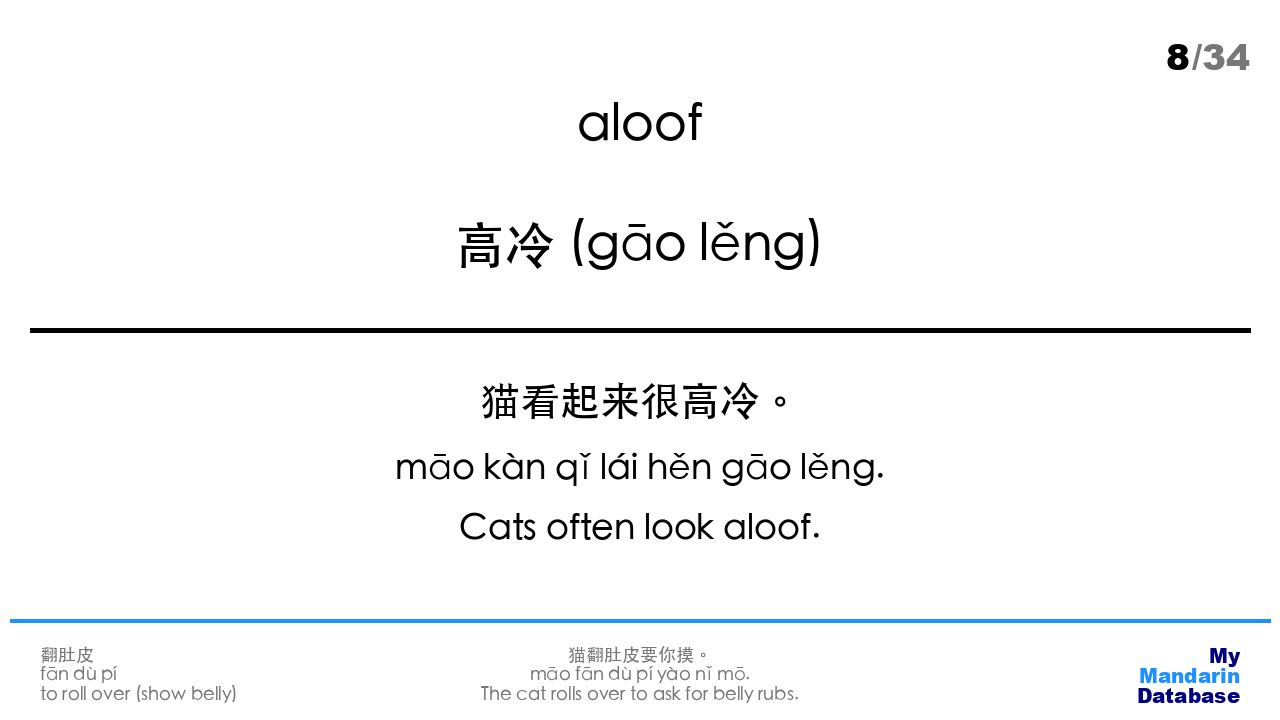

In [13]:
# Overall initializations
clips = []
previous_word = ''
previous_sent = ''

# Create folder to hold slide images
slides_path = f"{project_artifacts_folder}/slides"
if not os.path.exists(slides_path):
    os.mkdir(slides_path)

# Fill in defaults for any missing properties
for config_key, default_config_value in DEFAULT_TEXT_PROPERTIES.items():
    for vocab_slide_id, vocab_slide_settings in video_configs['vocab_slide'].items():
        if config_key not in vocab_slide_settings.keys():
            video_configs['vocab_slide'][vocab_slide_id][config_key] = default_config_value

# Iterate through each word
df_audio_durations_words_only = df_vocab_audio_durations.dropna(subset='sum_theory').reset_index(drop=True)
for word_idx, row in df_audio_durations_words_only.iterrows():
    # Initialize image
    print(f'Drawing {word_idx}: {row["chinese"]}')
    current_image_file_path = f"{slides_path}/{row['chinese']}"
    img = Image.new("RGB", video_configs['bg_size'], color=video_configs['bg_color'])
    draw = ImageDraw.Draw(img)
    
    # Header/Footer texts
    draw_word_index(draw, video_configs, n_vocab, word_idx)
    draw_logo(draw, video_configs)
    draw_previous_word(draw, video_configs, previous_word)
    draw_previous_sent(draw, video_configs, previous_sent)
    draw.line([
        (video_configs['footer_line']['x'], video_configs['bg_size'][1] - video_configs['footer_line']['y']),
        (video_configs['bg_size'][0] - video_configs['footer_line']['x'], video_configs['bg_size'][1] - video_configs['footer_line']['y'])],
        fill=video_configs['footer_line']['color'],
        width=video_configs['footer_line']['width'],
        joint=None)
    
    # Update previous
    previous_word = f"{row['chinese']}\n{row['pinyin']}\n{row['english']}"
    if data_settings['recording_id'] in ['013', 'ceword_csent', 'ceword_components_cesent', 'ceword_components_csent', 'ec_csent']:
        previous_sent = f"{row['sentence']}\n{row['sentence_pinyin']}\n{row['sentence_english']}"

    # Draw vocab depending on recording ID
    draw_vocab_based_on_format(data_settings['recording_id'], row, video_configs, current_image_file_path, img, draw, clips)

clips[23].display_in_notebook()

# 7. Create non-vocab slides


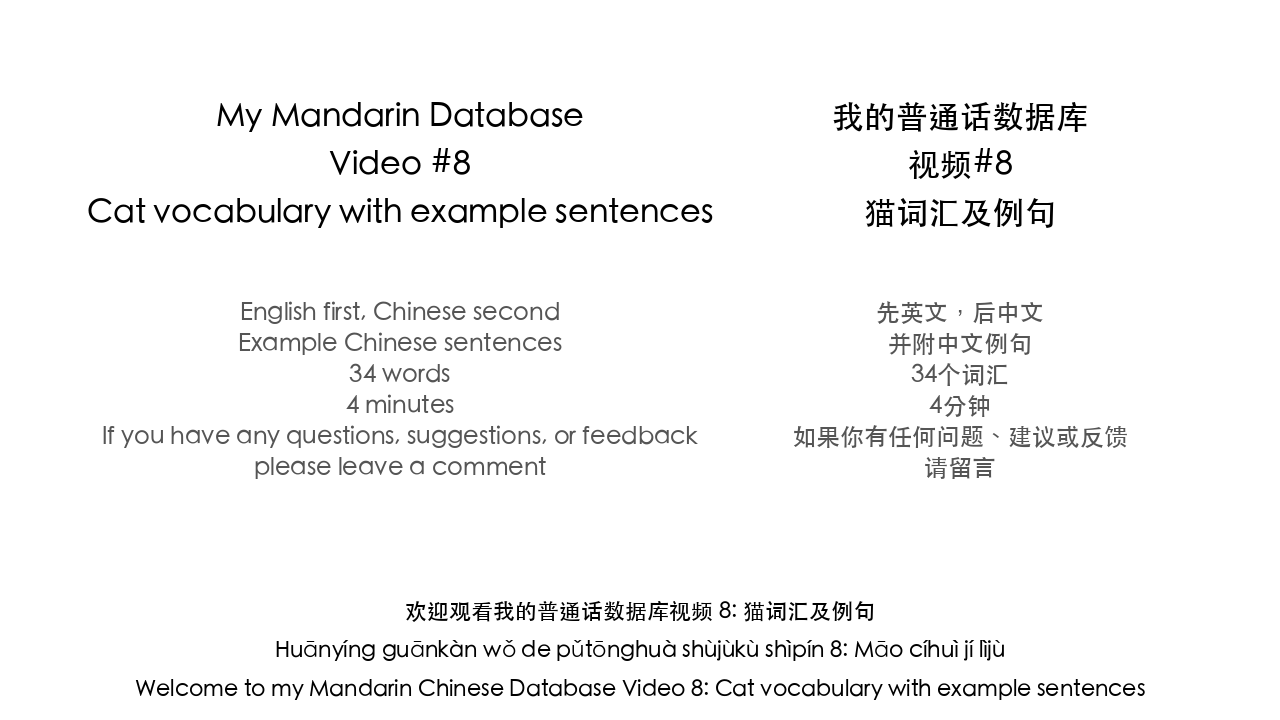

In [14]:
if 'intro' in nonvocab_slides.keys():
    img = generate_intro_slide(video_configs, nonvocab_slides['intro'], subtitle_text_configs, audio_filler_variables)
    img.save(f"{project_artifacts_folder}/intro.png")
my_img = ImageClip(f"{project_artifacts_folder}/intro.png", duration=1).with_start(0)
my_img.display_in_notebook()


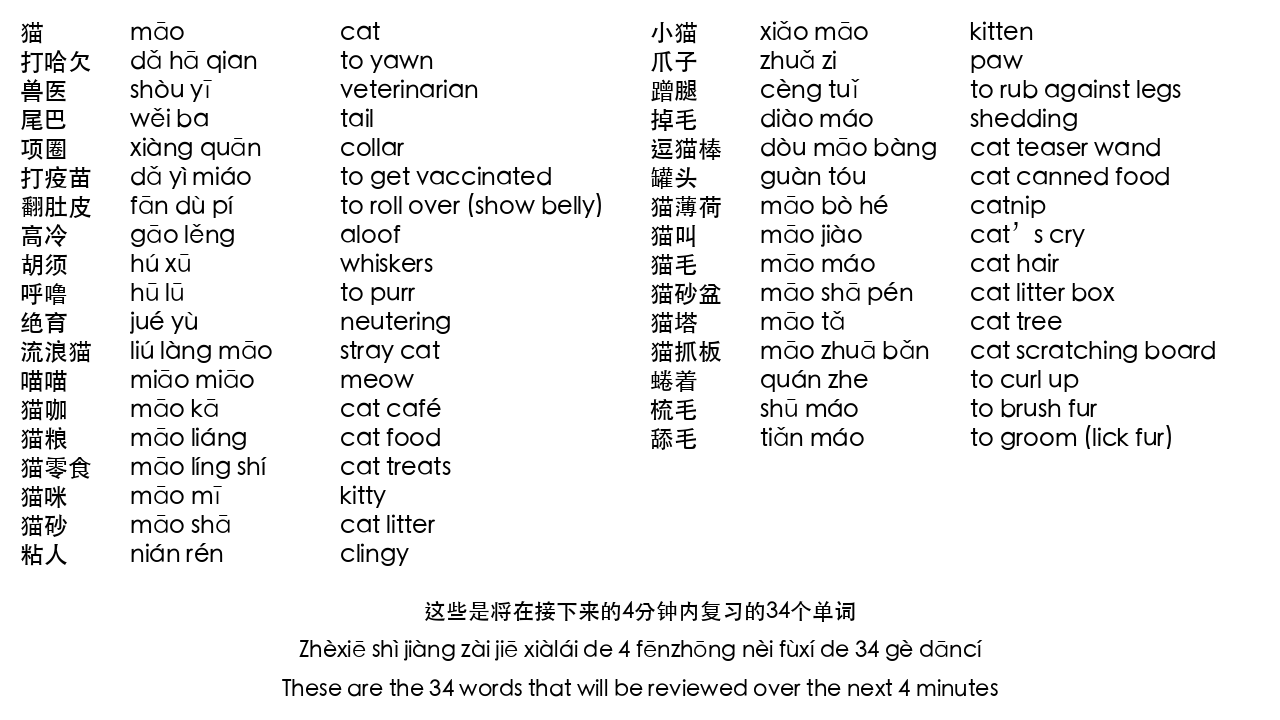

In [15]:
if 'word_list' in nonvocab_slides.keys():
    img = generate_word_list_slide(video_configs, nonvocab_slides['word_list'], subtitle_text_configs, df_audio_durations_words_only)
    img.save(f"{project_artifacts_folder}/word_list.png")
my_img = ImageClip(f"{project_artifacts_folder}/word_list.png", duration=1).with_start(0)
my_img.display_in_notebook()


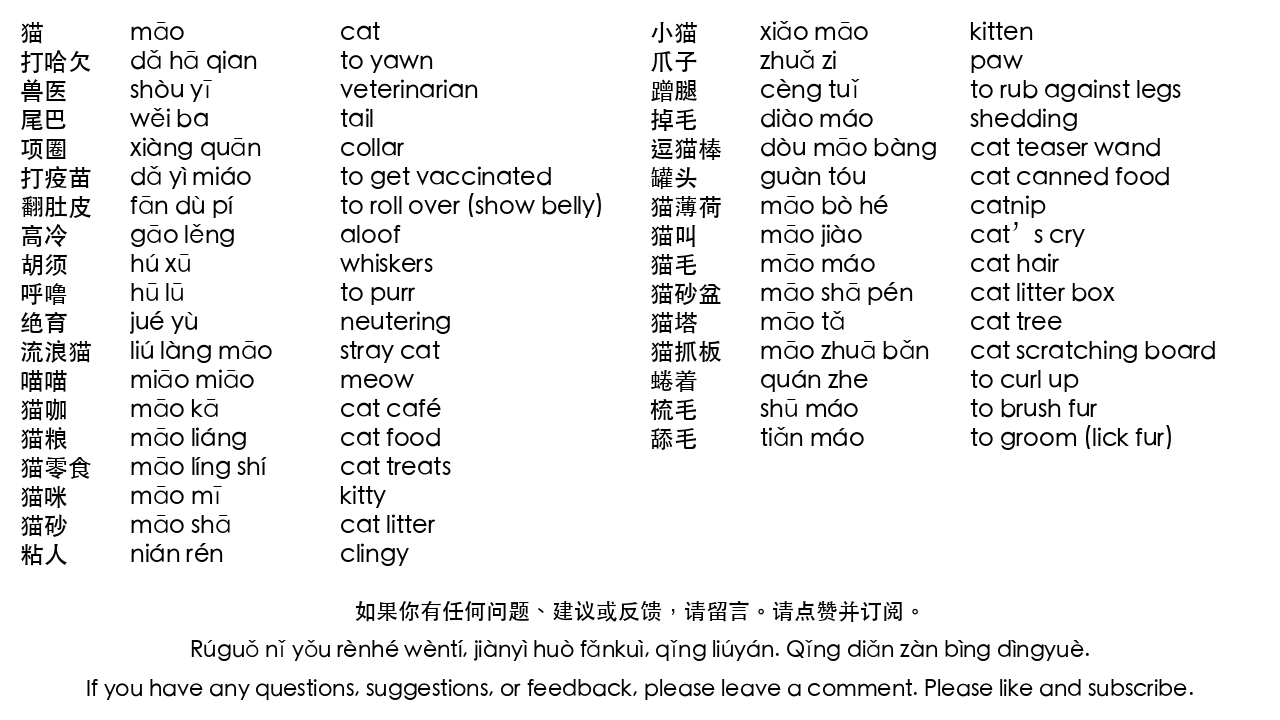

In [16]:
if 'outro' in nonvocab_slides.keys():
    img = generate_outro_slide(video_configs, nonvocab_slides['outro'], subtitle_text_configs, df_audio_durations_words_only)
    img.save(f"{project_artifacts_folder}/outro.png")
my_img = ImageClip(f"{project_artifacts_folder}/outro.png", duration=1).with_start(0)
my_img.display_in_notebook()

# 8. Create video icon


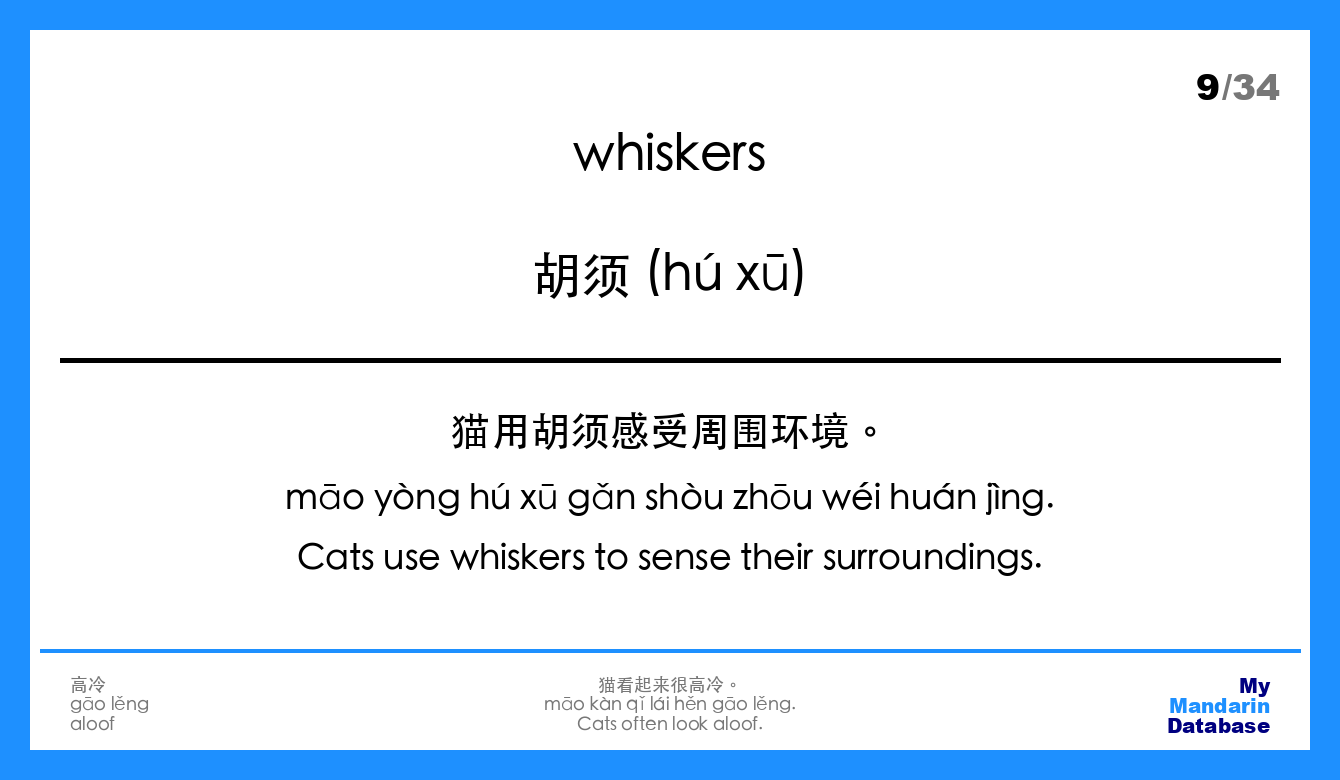

In [17]:
# icon_configs['word'] = '胡须'
img = create_icon_from_slide(icon_configs, video_configs, project_artifacts_folder)
img.save(f'{project_artifacts_folder}/icon.png')
my_img = ImageClip(f"{project_artifacts_folder}/icon.png", duration=1).with_start(0)
my_img.display_in_notebook()

# 9. Create video

In [18]:
combine_clips_with_audio_to_create_video(clips, nonvocab_slides, project_artifacts_folder)

Number of clips: 105
audio: 267.020s, video: 266.963s; difference: 0.057s
MoviePy - Building video output/videos/0930_ec_csent_cat/video.mp4.
MoviePy - Writing audio in videoTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
MoviePy - Writing video output/videos/0930_ec_csent_cat/video.mp4



MoviePy - Done !
MoviePy - video ready output/videos/0930_ec_csent_cat/video.mp4


# 10. Overlay another image on original icon


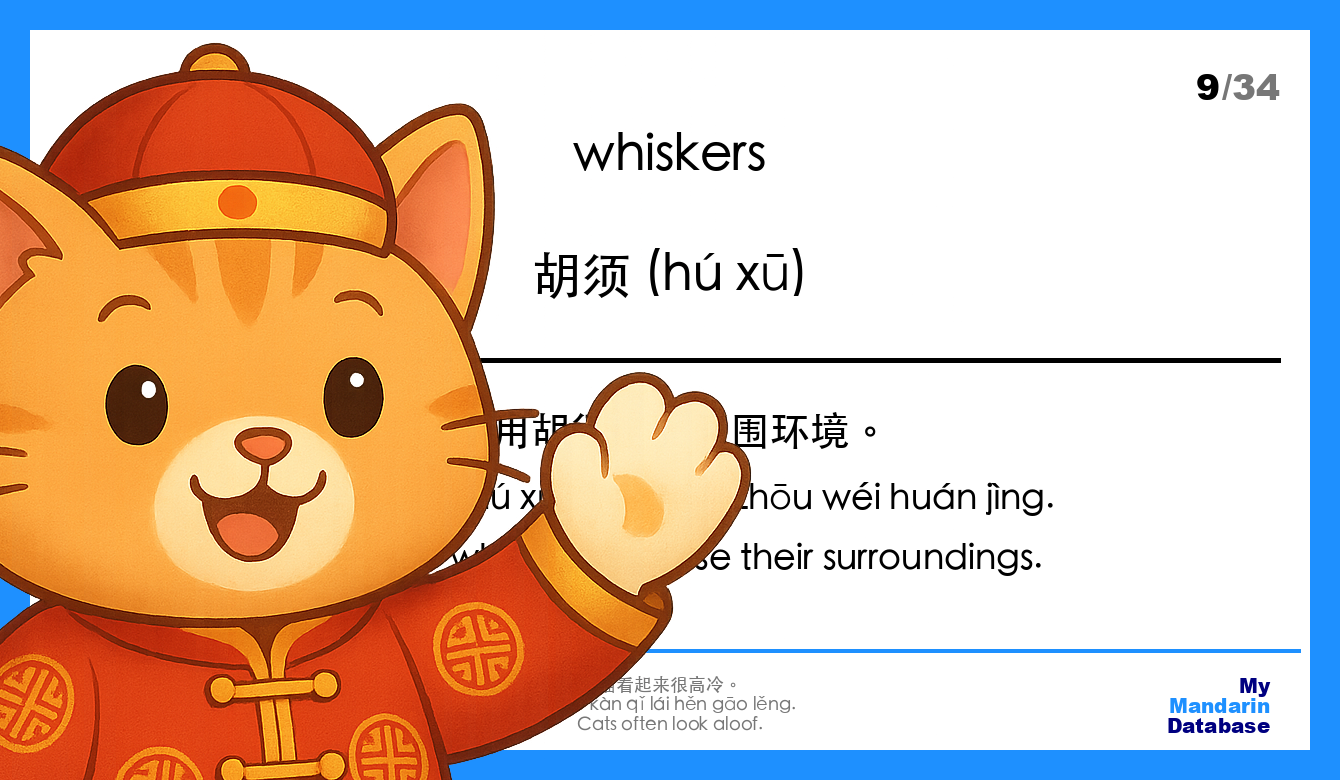

In [19]:
original_icon_path = f'{project_artifacts_folder}/icon.png'
mario_slide_path = f'{project_artifacts_folder}/chinese_cat.png'
new_image_path = f'{project_artifacts_folder}/icon_with_pic.png'
xy_offset = (-500, 0)
new_img = overlay_one_image_on_another(original_icon_path, mario_slide_path, xy_offset, new_image_path)
new_img.display_in_notebook()

